# Grupo 7

### Ejercicio 9 

#### Andrés Felipe Botero, Diego Alejandro Díaz, Juliana López Botero, Carolina Niño Gutiérrez

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics


### Car Price Prediction
##### Predict if the price of a car is low or high

In [2]:
data = pd.read_csv('/Users/carolinaninogutierrez/Desktop/MODELOS_AVANZADOS/ENTREGA2/E9/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape


(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Exercise 8.1

Estimate a Decision Tree Classifier Manually using the code created in the decision trees notebook.

Evaluate the accuracy on the testing set

In [6]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

<AxesSubplot:xlabel='Year', ylabel='Mileage'>

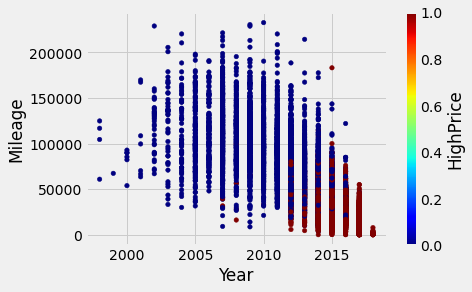

In [7]:
# scatter plot of HighPrice versus Hits colored by Salary
data.plot(kind='scatter', x='Year', y='Mileage', c='HighPrice', colormap='jet') 

In [8]:
data.HighPrice.describe()

count    13150.000000
mean         0.579544
std          0.493651
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: HighPrice, dtype: float64

In [9]:
#define X y Y
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

#### Building a Decision Tree by hand

In [10]:
max_depth = None  ## maxima profundidad del árbol - numero de pisos
num_pct = 10
max_features = None
min_gain=0.001

For feature 1 calculate possible splitting points

In [11]:
j = 1
print(X_train.columns[j])

Mileage


In [12]:
# Split the variable in num_ctp points
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
# Only unique values for filter binary and few unique values features
splits = np.unique(splits)
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [13]:
k=5

In [14]:
filter_l = X.iloc[:, j] < splits[k]
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

#### Se calcula el GINI

In [15]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [16]:
gini_l = gini(y_l)
gini_l

0.20562506325087826

In [17]:
gini_r = gini(y_r)
gini_r

0.3991431537249346

### Todo en una función

In [18]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [19]:
gini_impurity(X.iloc[:, j], y, splits[k])


0.18496148274516044

### Probando todas las divisiones en todas las funciones

In [20]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [21]:
j, split, gain = best_split(X, y, 10)
j, split, gain

(1, 51704.54545454545, 0.23348567756020572)

## El mejor punto para generar las ramas por izquierda y por derecha es 51704.5454



In [22]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [23]:
y.shape[0], y_l.shape[0], y_r.shape[0]


(13150, 8368, 4782)

In [24]:
y.mean(), y_l.mean(), y_r.mean()


(0.5795437262357415, 0.8378346080305927, 0.1275616896695943)

In [25]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [26]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)


{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': -1,
  'n_samples': 8368,
  'gain': 0.0359166442135464},
 'sr': {'y_pred': 0,
  'y_prob': 0.12771739130434784,
  'level': 1,
  'split': -1,
  'n_samples': 4782,
  'gain': 0.04846022210319853}}

In [27]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=4, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 8368,
  'gain': 0.0359166442135464,
  'sl': {'y_pred': 0,
   'y_prob': 0.3403880070546737,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 565,
   'gain': 0.06001982703810749,
   'sl': {'y_pred': 0,
    'y_prob': 0.058823529411764705,
    'level': 3,
    'split': [2, 1.0],
    'n_samples': 151,
    'gain': 0.005661757290357922,
    'sl': {'y_pred': 0,
     'y_prob': 0.03816793893129771,
     'level': 4,
     'split': -1,
     'n_samples': 129,
     'gain': 0.0013410125277138474},
    'sr': {'y_pred': 0,
     'y_prob': 0.20833333333333334,
     'level': 4,
     'split': -1,
     'n_samples': 22,
     'gain': 0.14348025711662085}},
   'sr': {'y_pred': 0,
    'y_prob': 0.44471153846153844,
    'level': 3,
    'split': [1, 41369.63636363

### Predicción del árbol

In [28]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [29]:
a=tree_predict(X_test, tree, proba=False)
len(a)

4340

### Accuracy

In [30]:
metrics.accuracy_score(a,y_test)


0.8670506912442396

## accuracy del 86.70%.



In [31]:
threshold = 0
accuracy_scores = []

p=tree_predict(X_test, tree, proba=True)
p

for threshold in range(1,101,1):
    y_pred = (p >= threshold/100).astype(np.int)
    accuracy_scores.append(metrics.accuracy_score(y_pred,y_test))

Text(0, 0.5, 'Accuracy')

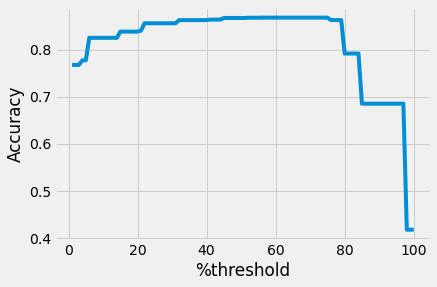

In [32]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(range(1,101,1), accuracy_scores)
plt.xlabel('%threshold')
plt.ylabel('Accuracy')

In [33]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(55, 0.867741935483871)

## Nuestro mejor accuracy fue de 86.77% tomando un threshold del 55%

#### Evaluando la precisión en el testing set

In [34]:
# list of values to try for max_depth
max_depth_range = range(1, 10)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

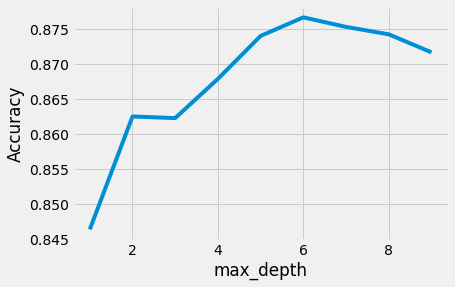

In [35]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

#### muestra la mejor precisión y el max_depth correspondiente

In [36]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8767300380228138, 6)

### max_depth = 6 es el mejor, así que ajusta un árbol usando ese parámetro

In [37]:
clf = DecisionTreeClassifier(max_depth=6, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=6, random_state=1)

### Para las feature_cols se quita la variable respuesta

In [38]:
feature_cols = data.columns[data.columns.str.startswith('C') == False].drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [39]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
3,M_Camry4dr,0.000000
4,M_CamryBase,0.000000
7,M_CamrySE,0.000007
5,M_CamryL,0.000389
2,M_Camry,0.007466
8,M_CamryXLE,0.009693
6,M_CamryLE,0.017950
0,Year,0.172331
1,Mileage,0.792163


In [40]:
pd.Series(cross_val_score(clf, X, y, cv=10)).describe()


count    10.000000
mean      0.876730
std       0.010448
min       0.862357
25%       0.868821
50%       0.874905
75%       0.884791
max       0.893536
dtype: float64

# Exercise 8.2
Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in bagging notebook.

Evaluate the accuracy on the testing set

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor


In [43]:
n_estimators = 10
# set a seed for reproducibility
np.random.seed(123)

n_samples = X_train.shape[0]

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]
from sklearn.tree import DecisionTreeClassifier

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

In [44]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred_df

,0,1,2,3,4,5,6,7,8,9
332784,0,0,0,0,1,1,0,1,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
244795,1,1,1,1,1,1,1,1,1,1
366403,1,0,0,0,0,0,0,0,0,0
269482,1,1,1,1,1,1,1,1,1,1
5010,1,1,1,1,1,1,1,1,1,1


In [45]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

from sklearn import metrics
metrics.f1_score(y_pred, y_test)

0.8658823529411764

In [46]:
metrics.accuracy_score(y_pred, y_test)


0.8423963133640553

####  Nuestro modelo tiene un f1 score de 86,6%  y un accuracy de 84,2%


# Exercise 8.3
Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [47]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)


Text(0, 0.5, 'Accuracy')

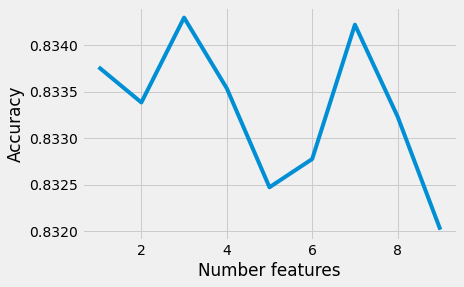

In [49]:
# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for feature in feature_range:
    clf = DecisionTreeClassifier( random_state=1, max_features=feature)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
  
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, accuracy_scores)
plt.xlabel('Number features')
plt.ylabel('Accuracy')

In [50]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(2, 0.8342965779467679)

In [51]:
feature_range[2]


3

### con tres features, se encuentra el mejor accuracy de 83.429%

## Profundidad

Text(0, 0.5, 'Accuracy')

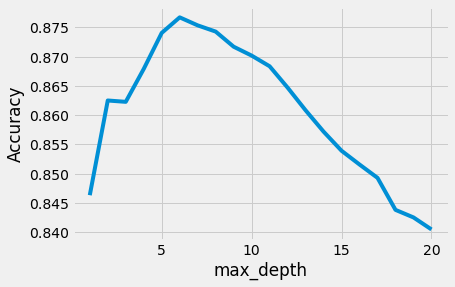

In [52]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [53]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(5, 0.8767300380228138)

In [54]:
max_depth_range[5]


6

### La mejor profundidad es de 6

Text(0, 0.5, 'Accuracy')

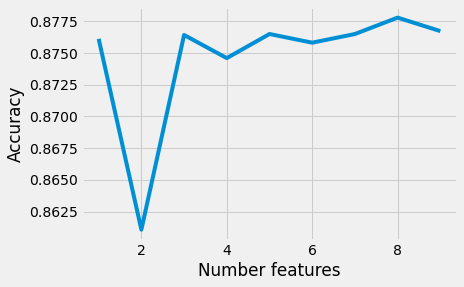

In [55]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)

# list to store the average Accuracy for each value of max_features
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for feature in feature_range:
    clf = DecisionTreeClassifier( max_depth=6, random_state=1, max_features=feature)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())
  
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(feature_range, accuracy_scores)
plt.xlabel('Number features')
plt.ylabel('Accuracy')

In [56]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(7, 0.8777946768060836)

In [57]:
feature_range[7]


8

In [58]:

acc_DTF=max(accuracy_scores)
print(acc_DTF)

0.8777946768060836


### El el mejor accuracy de 87.794% con 8 Features

# Exercise 8.4
Estimate a Bagging of 10 Decision Tree Classifiers with max_features = log(n_features)

Evaluate the accuracy on the testing set

In [59]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier( max_features="log2"), n_estimators=10, bootstrap=True,
                        random_state=123, n_jobs=-1, oob_score=True)

clf.fit(X_train, y_train)
p = clf.predict(X_test)
auc_DT=metrics.accuracy_score(p,y_test)
print(auc_DT)

0.8352534562211982


/Users/carolinaninogutierrez/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/carolinaninogutierrez/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:642: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = (predictions /


### Con Log encontramos un accuracy de 83.52%

In [60]:
p = clf.predict_proba(X_test)
p = p[:,1]
p

array([0.2, 1. , 1. , ..., 1. , 1. , 0.1])

Text(0, 0.5, 'Accuracy')

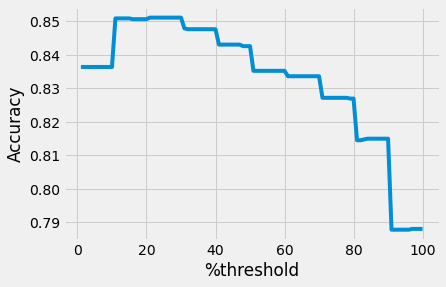

In [61]:
threshold = 0
accuracy_scores = []

for threshold in range(1,101,1):
    y_pred = (p >= threshold/100).astype(np.int)
    accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
    
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(range(1,101,1), accuracy_scores)
plt.xlabel('%threshold')
plt.ylabel('Accuracy')


In [62]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(20, 0.8511520737327188)

In [63]:

acc_bag10=max(accuracy_scores)
print(acc_bag10)

0.8511520737327188


## Exercise 8.5
Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf_rf = RandomForestClassifier()

pd.Series(cross_val_score(clf_rf, X, y, cv=10)).describe()


count    10.000000
mean      0.836046
std       0.011172
min       0.821293
25%       0.830989
50%       0.833840
75%       0.840875
max       0.858555
dtype: float64

In [65]:
from sklearn import metrics
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
acc_RF=metrics.accuracy_score(y_pred, y_test.values)
print(acc_RF)

0.8377880184331797


### El RandomForestClassifier usando sklearn es de 83,78%

# Exercise 8.6
Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

### Max features

In [66]:
feature_cols = X_train.columns
feature_range = range(1, len(feature_cols)+1)

accuracy_scores = []

# Se usan 10-fold para el cross-validation en el rango columnas de features
for feature in feature_range:
    clf_rf = RandomForestClassifier(n_estimators=11, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf_rf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

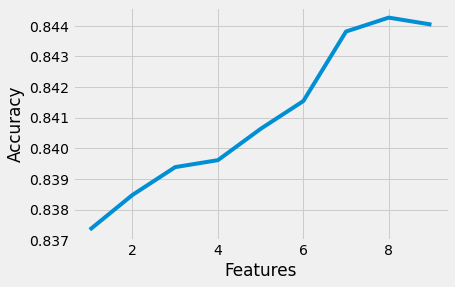

In [67]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.plot(feature_range, accuracy_scores)
plt.xlabel('Features')
plt.ylabel('Accuracy')

In [68]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(7, 0.8442678774120317)

### Con un accuracy de 84,426% y 7 features

### N estimators

In [69]:
estimator_range = range(1, 30, 5)
accuracy_scores = []

# Se usan 10-fold para el cross-validation en el rango de estimación de 1 a 10 n_estimators
for estimator in estimator_range:
    clf_rf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf_rf, X_train, y_train, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

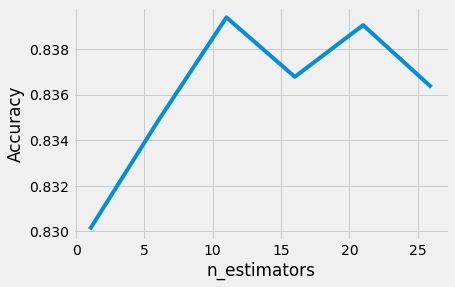

In [70]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [71]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(2, 0.8393870601589104)

In [73]:
estimator_range[2]


11

### El mejor accuracy se logra con 11 estimadores, este accuracy corresponde a 83,93%.



## Max Depth

In [74]:
max_depth_range = range(1, 21)
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth

for depth in max_depth_range:
    clf = RandomForestClassifier(max_depth=depth, max_features= 8, n_estimators= 11, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

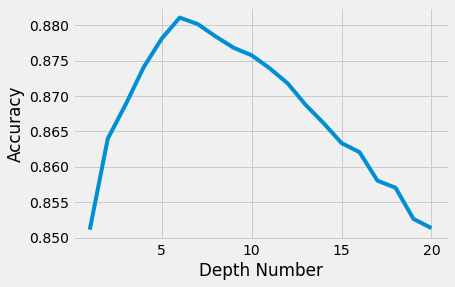

In [75]:
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('Depth Number')
plt.ylabel('Accuracy')

In [76]:
accuracy_scores.index(max(accuracy_scores)),max(accuracy_scores)


(5, 0.8810646387832701)

### accuracy de 88.10%. con depth = 6



## Random Forest

#### max_depth=6
#### max_features= 8
#### n_estimators= 11  


In [77]:
clf = RandomForestClassifier(max_depth=6, n_estimators=11, max_features=8, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_RFC= metrics.accuracy_score(y_pred, y_test.values)
print(acc_RFC)

0.8806451612903226


# Exercise 8.7
Using xgboost train a XGBClassifier

Evaluate the accuracy on the testing set

In [79]:
from xgboost import XGBClassifier
from sklearn import metrics

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ModuleNotFoundError: No module named 'xgboost'

### Accuracy

In [80]:
#Accuracy
acc_XGB= metrics.accuracy_score(y_pred, y_test.values)
print(acc_XGB)

0.8806451612903226


# Exercise 8.8
Using xgboost train a XGBClassifier

Modify the parameters learning rate, gamma, colsample_bytree. Explain what each parameter means.

Evaluate the accuracy on the testing set

In [81]:
# Se establece la grilla de parámetros a calibrar
parameters = {
        'learning_rate': [0.08,0.09, 0.1, 0.11,0.12,0.13,0.14,0.2,0.3],
        'gamma': [0.5,0.7,0.8,0.9,1,1.1,1,2,1,3, 1.5, 2, 5,7,9,15],
        'colsample_bytree': [0.75, 0.8,0.85,0.9, 1.0],
        }

In [82]:
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1)

NameError: name 'XGBClassifier' is not defined

In [83]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [84]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
param_comb = 7


folds=10
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=10, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

#Timer y random search
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) 

NameError: name 'xgb' is not defined

In [85]:
#Impresión de resultados

print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
#results.to_csv('xgb-random-grid-search-results-01.csv', index=False)
print(results)


 All results:


NameError: name 'random_search' is not defined

In [86]:
xgb2 = XGBClassifier(learning_rate=0.12,gamma=1.5,colsamble_bytree=0.9)


NameError: name 'XGBClassifier' is not defined

In [87]:
xgb2.fit(X_train, y_train)
y_pred = xgb2.predict(X_test)
acc_XGBC= metrics.accuracy_score(y_pred, y_test.values)
print(acc_XGBC)

NameError: name 'xgb2' is not defined

### El accuracy es de 88.29%, mejor que el del modelo sin calibrar con accuracy de 87.9%



In [ ]:
# Comparación de Accuracy
from tabulate import tabulate
table = [['Modelo', 'Accuracy'],['Bagging Decision Tree by hand', acc_bag10],['Bagging Decision Tree by hand Calibrado', acc_DTF],['Random Forest Sktlearn', acc_RF], ['Random Forest Calibrado', acc_RFC],['XGBoost Sktlearn', acc_XGB],['XgBoost Calibrado', acc_XGBC]]
print(tabulate(table))


## Como conclusión observamos que los modelos después de la calibración de parámetros obtienen un mejor desempeño.